# Calculation of Vertical Dynamic Ocean Modes #
Downloaded from https://www.eoas.ubc.ca/~sallen/AIMS-workshop/_modules/dynmodes.html. The here used python code is based on http://woodshole.er.usgs.gov/operations/sea-mat/klinck-html/dynmodes.html by John Klinck, 1999.

Python function that calculates numerical solutions of the generalized eigenvalue problem expressed by:
$$\frac{\partial^2}{\partial z^2} w_m + \alpha^2 N^2 w_m = 0$$

with boundary conditions of $w_m = 0$ at the surface and the bottom.
Variables:

* $z$ is the vertical coordinate, measured in $[m]$
* $w_m$ are the vertical velocity modes
* $N^2$ is a profile of Brunt-Vaisala buoyancy frequencies $[s^{-2}]$
* $\alpha^2 = \frac{1}{c^2}$ are the eigenvalues

The inputs to our Python function will be:

* `Nsq`: an array of Brunt-Vaisala buoyancy frequencies $[s^{-2}]$ ; i.e. $N^2$
* `depth`: an array of depths $[m]$ that will be used as the vertical coordinates; i.e. $z$
* `nmodes`: number of vertical modes to calculate

The outputs will be:
* `wmodes`: the array of vertical velocity modes; i.e. $w_m$
* `pmodes`: the array of horizontal velocity modes
* `rmodes`: the array of vertical density modes
* `ce`: the array of modal wave speeds $[m / s]$


#### Modes will be calculated using squared buoyancy frequencies avaraged approx in a 0.5$^{\circ}$ radius around 23$^{\circ}$W, 0$^{\circ}$ using CTD profiles from Claus et al. (2016), Kopte et al. (2018) and an extended set includeing more recent data as well as INALT20 model output for JRA and CORE hindcasts experiments

## Load Python Packages

In [1]:
import gsw
import seawater as sw
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from pathlib import Path
from scipy.io import loadmat
from datetime import datetime
%matplotlib inline

## Preamble

In [2]:
# output
out_dir_data = Path('../data/INALT20_dynmodes')
Path(out_dir_data).mkdir(parents=True, exist_ok=True)
out_dir_fig = Path('../figures/INALT20_dynmodes')
Path(out_dir_fig).mkdir(parents=True, exist_ok=True)
out_obs = 'Updated_ctd_ta_23W_modes.nc'
out_JRA = 'JRA_ta_23W_modes.nc'
out_CORE = 'CORE_ta_23W_modes.nc'

In [3]:
# input observations
indir_obs = Path('../data/23W_ship_section/Burmeister_et_al_2021/')
file_name_obs = 'N2_profiles_23w0n_merged_all.mat'
file_name_claus = '../data/ctd_ta_23W_modes.nc'

In [4]:
# input model
in_dir = Path('../data/INALT20_dynmodes/')

calc_JRA = 1 #set 1 if annual mean should be recalculated
calc_CORE = 1 #set 1 if annual mean should be recalculated
JRA_path = "INALT20.L46-KFS10X"
exp_id = "INALT20.L46-KFS10?"
CORE_path = "shared/INALT20.L46-KFS044-S"
CORE_exp_id = "INALT20.L46-KFS044" # INALT COREv2

temp_res = "_5d_" # 5d:5-daily; 1m:monthly; 1y:yearly; 1d:daily(stored currently on TAPE) 
nest_prefix = "1_" # "1_" for high resolution; leave empty for base model
files_JRA = list(sorted(in_dir.glob(f"{nest_prefix}{exp_id}*grid_T.nc")))
files_CORE = list(sorted(in_dir.glob(f"{nest_prefix}{CORE_exp_id}*grid_T.nc")))

aux_files = list(sorted(in_dir.glob(f"{nest_prefix}[m,n]*.nc")))

## Load data

In [5]:
# basin modes from CLAUS2016 for comparisom
ds_moor = xr.open_dataset(file_name_claus)

# updated observations
section = loadmat((indir_obs/file_name_obs))

In [6]:
# model
ds_mesh = xr.open_dataset(aux_files[0])

ds_JRA = xr.open_mfdataset(files_JRA,combine='by_coords')
ds_JRA = ds_JRA.sel(time_counter=slice('1980','2009')) 
ds_JRA.coords['depth']=ds_mesh.gdept_0.squeeze().rename({'z':'deptht'})
ds_JRA.coords['tmask']=ds_mesh.tmask.squeeze().rename({'z':'deptht'})
ds_JRA.coords['lon']=ds_mesh.glamt.squeeze().mean('y')
ds_JRA.coords['lat']=ds_mesh.gphit.squeeze().mean('x')
ds_JRA = ds_JRA.where(ds_JRA.tmask)
ds_JRA = ds_JRA.mean(['x','y'])
ds_JRA.coords['depth']=ds_mesh.gdept_0.squeeze().rename({'z':'deptht'}).mean(['x','y'])
ds_JRA = ds_JRA.swap_dims({'deptht':'depth'}
                ).drop_vars(['deptht','time_centered']).compute()
# ds_JRA = ds_JRA.swap_dims({'y':'lat','x':'lon'}
#                 ).sel(lat=0,lon=-23,method='nearest').swap_dims({'deptht':'depth'}
#                 ).drop_vars(['deptht','nav_lat','nav_lon',
#                              'time_centered','time_counter_bounds','time_centered_bounds']).compute()

ds_CORE = xr.open_mfdataset(files_CORE,combine='by_coords')
ds_CORE = ds_CORE.sel(time_counter=slice('1980','2009'))
ds_CORE['time_counter']=ds_JRA.time_counter
ds_CORE.coords['depth']=ds_mesh.gdept_0.squeeze().rename({'z':'deptht'})
ds_CORE.coords['tmask']=ds_mesh.tmask.squeeze().rename({'z':'deptht'})
ds_CORE.coords['lon']=ds_mesh.glamt.squeeze().mean('y')
ds_CORE.coords['lat']=ds_mesh.gphit.squeeze().mean('x')
ds_CORE = ds_CORE.where(ds_CORE.tmask)
ds_CORE = ds_CORE.mean(['x','y'])
ds_CORE.coords['depth']=ds_mesh.gdept_0.squeeze().rename({'z':'deptht'}).mean(['x','y'])
ds_CORE = ds_CORE.swap_dims({'deptht':'depth'}
                ).drop_vars(['deptht','time_centered']).compute()
# ds_CORE = ds_CORE.swap_dims({'y':'lat','x':'lon'}
#                 ).sel(lat=0,lon=-23,method='nearest').swap_dims({'deptht':'depth'}
#                 ).drop_vars(['deptht','nav_lat','nav_lon',
#                              'time_centered','time_counter_bounds','time_centered_bounds']).compute()



/gxfs_work/geomar/smomw294/.conda/envs/INALT_wind_forcing/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/gxfs_work/geomar/smomw294/.conda/envs/INALT_wind_forcing/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


## Create Functions

In [7]:
def calc_N2_sw(ds,p):
    ds = ds.swap_dims({'depth':'pres'}).interp(pres=p).transpose('pres','time_counter','axis_nbounds')
    s = np.ma.array(ds.vosaline.values, mask=np.isnan(ds.vosaline.values))
    t = np.ma.array(ds.votemper.values, mask=np.isnan(ds.votemper.values))
    p = ds.pres.values
    lat = 0
    
    # %% compute Nsq
    z_mid = (p[1:] + p[:-1]) / 2.
    zn = np.r_[0., z_mid, z_mid[-1] + p[-1] - p[-2]]
    Nsq,q,pmid = sw.bfrq(s, t, p[:,np.newaxis], lat=lat)
    Nsq = Nsq.mean(axis=-1)
    Nsq = np.r_[Nsq[0], Nsq, Nsq[-1]]
    
    N2 = xr.Dataset(data_vars=dict(N2=(['p_mid'],Nsq)),
                         coords=dict(
                             p_mid=(['p_mid'],np.array(-1*zn,dtype='float64'))
                         ))
    N2.N2.attrs['long_name'] = ('Squared Buoyancy Frequency')
    N2.N2.attrs['units']='second ** (-2)'
    N2.coords['p_mid'] = N2.p_mid
    return N2

In [8]:
def data_struc(N2,depth_w,wm,pm,rm,c,Nmodes):
    depth_p = ((depth_w[1:] + depth_w[:-1]) / 2.)
    dsm_obs = xr.Dataset(
        data_vars = dict(
            wstruc=(['mode','depth_w'],wm,
                   {'long_name': 'Vertical structure function of vertical velocity',
                    'units': 'meter'}),
            pstruc=(['mode','depth_p'],pm,
                   {'long_name': 'Vertical structure function of pressure',
                    'units': ''}),
            rstruc=(['mode','depth_w'],rm,
                   {'long_name': 'Vertical structure function of density',
                    'units': 'meter / seconds**2'}),
            Nsq=(['depth_w'],N2,
                 {'long_name': 'Squared Buoyancy Frequency',
                  'units': 'second ** (-2)'}),
            c=(['mode'],c,
              {'long_name': 'Gravity Wave Speed',
               'units':'meter / second'})
        ),
        coords=dict(
            depth_w=(['depth_w'],depth_w,
                   {'long_name': 'Z coordinate',
                    'units' : 'm',
                    'positive' : 'down'}),
            depth_p=(['depth_p'],depth_p,
                   {'long_name': 'Z coordinate',
                    'units' : 'm',
                    'positive' : 'down'}),
            mode=('mode',np.arange(1,Nmodes+1),
                 {'long_name': 'Mode number',
                  'units' : ''})
        ),
        attrs=dict(description='Vertical structure functions for stratification',
                history='Created by https://github.com/Kristin-2002/Wind_forcing/blob/master/scripts/INALT20_dynmodes.ipynb at {}'.format(datetime.now()),
                author='Kristin Burmeister, kristin.burmeister@sams.ac.uk, ORCID 0000-0003-3881-0298')
    )
    dsm_obs['pstruc'] = dsm_obs.pstruc*np.sign(dsm_obs.pstruc.isel(depth_p=1))
    dsm_obs['pstruc'] = dsm_obs.pstruc/dsm_obs.pstruc.std('depth_p')/ 4500**0.5
    
    return dsm_obs

#### Model decomposition
We going to break the implementation into 3 functions to improve readability and testability of the code.
First:

`build_d2dz_matrix`:

  * build the matrix that discretized $\frac{\partial^2}{\partial z^2}$ over the vertical coordinate,
    and applies the boundary conditions

In [9]:
def build_d2dz2_matrix(depth):
    """Build the matrix that discretizes the 2nd derivative
    over the vertical coordinate, and applies the boundary conditions.
    """
    zed = -depth
    # Number and size (in [m]) of vertical coordinate grid steps
    nz = zed.size
    dz = zed[:nz - 1] - zed[1:]
    # Grid step midpoints
    z_mid = zed[:nz - 1] - 0.5 * dz[:nz - 1]
    # Size of steps between grid step midpoints
    dz_mid = np.zeros_like(zed)
    dz_mid[1:dz_mid.size - 1] = z_mid[:nz - 2] - z_mid[1:nz - 1]
    dz_mid[0] = dz_mid[1]
    dz_mid[dz_mid.size - 1] = dz_mid[dz_mid.size - 2]
    # 2nd derivative matrix matrix
    d2dz2 = np.zeros((nz, nz))
    # Elements on the diagonal
    diag_index = np.arange(1, nz - 1)
    d2dz2[diag_index, diag_index] = (
        1 / (dz[:nz - 2] * dz_mid[1:nz - 1]) + 1 / (dz[1:nz - 1] * dz_mid[1:nz - 1]))
    # Elements on the super-diagonal
    diag_index_p1 = np.arange(2, nz)
    d2dz2[diag_index, diag_index_p1] = -1 / (dz[:nz - 2] * dz_mid[1:nz - 1])
    # Elements on the sub-diagonal
    diag_index_m1 = np.arange(nz - 2)
    d2dz2[diag_index, diag_index_m1] = -1 / (dz[1:nz - 1] * dz_mid[1:nz - 1])
    # Boundary conditions
    d2dz2[0, 0] = d2dz2[nz - 1, 0] = -1
    return d2dz2, nz, dz

Once the eigenvalues and modes have been calculated,
we need to clean up numerical artifacts,
and prepare the eigenvalues and modes to be output:
`clean_up_modes`:
  * exclude complex-valued (non-physical) eigenvalues and their corresponding modes
  * exclude near-zero and negative eigenvalues and their corresponding modes
  * sort the eigenvalues and modes by increasing eigenvalue magnitude
  * truncate the set to the number of modes that were requested for the calculation.

In [10]:
def clean_up_modes(eigenvalues, wmodes, nmodes):
    """Exclude complex-valued and near-zero/negative eigenvalues and their modes.
    Sort the eigenvalues and mode by increasing eigenvalue magnitude,
    and truncate the results to the number of modes that were requested.
    """
    # Transpose modes to that they can be handled as an array of vectors
    wmodes = wmodes.transpose()
    # Filter out complex-values and small/negative eigenvalues and corresponding modes
    mask = np.imag(eigenvalues) == 0
    eigenvalues = eigenvalues[mask]
    wmodes = wmodes[mask]
    mask = eigenvalues >= 1e-10
    eigenvalues = eigenvalues[mask]
    wmodes = wmodes[mask]
    # Sort eigenvalues and modes and truncate to number of modes requests
    index = np.argsort(eigenvalues)
    eigenvalues = eigenvalues[index[:nmodes]]
    wmodes = wmodes[index[:nmodes]]
    return eigenvalues, wmodes

Finally,
we put everything together:
`dynmodes`:
  * build the del-squared matrix
  * solve the generalized eigenvalue problem
  * clean up the eigenvalue and vertical mode results
  * calculate the modal speeds
  * calculate the horizontal modes by differention of the vertical modes

In [11]:
def dynmodes(Nsq, depth, nmodes):
    """Calculate ocean dynamic vertical modes
    taking a column vector of Brunt-Vaisala values (Nsq) at
    different depths (depth) and calculating some number of
    dynamic modes (nmodes).

    Based on http://woodshole.er.usgs.gov/operations/sea-mat/klinck-html/dynmodes.html
    by John Klinck, 1999.
    """

    # 2nd derivative matrix plus boundary conditions
    d2dz2, nz, dz = build_d2dz2_matrix(depth)
    # N-squared diagonal matrix
    Nsq_mat = np.identity(nz) * Nsq
    # Solve generalized eigenvalue problem for eigenvalues and vertical velocity modes
    eigenvalues, wmodes = scipy.linalg.eig(d2dz2, Nsq_mat)
    eigenvalues, wmodes = clean_up_modes(eigenvalues, wmodes, nmodes)
    # Vertical density modes
    rmodes = wmodes * Nsq
    # Modal speeds
    ce = np.real(1 / np.sqrt(eigenvalues))
    # Horizontal velocity modes
    pmodes = np.zeros_like(wmodes)
    # 1st derivative of vertical modes
    pmodes = np.diff(wmodes) / dz
#     # Linear interpolation on to the vertical coordinate grid
#     pmodes[:, 1:nz - 1] = (pr[:, 1:nz - 1] + pr[:, :nz - 2]) / 2
#     pmodes[:, 0] = pr[:, 0]
#     pmodes[:, nz - 1] = pr[:, nz - 2]
    
    return data_struc(Nsq, abs(depth), wmodes, pmodes, rmodes, ce, nmodes)

Let's define a helper function to plot $N^2$ and the 3 sets of modes returned by `dynmodes`:

In [12]:
def plot_modes(Nsq, depth, nmodes, wmodes, pmodes, rmodes):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(2, 2, 1)
    # Nsq
    ax.plot(Nsq, -depth)
    ax.ticklabel_format(style='sci', scilimits=(0,0), axis='x')
    ax.set_ylabel('z')
    ax.set_xlabel('N^2')
    ax.grid()
    # modes
    mode_sets = [
      # (values, subplot number, x-axis title)
        (wmodes, 2, 'wmodes'),
        (pmodes, 3, 'pmodes'),
        (rmodes, 4, 'rmodes'),
    ]
    for mode_set in mode_sets:
        modes, subplot, title = mode_set
        ax = fig.add_subplot(2, 2, subplot)
        for i in range(nmodes):
#             if title == 'pmodes':
#                 s = np.sign(modes[i][0])
#             else:
            s=1
            ax.plot(s*modes[i], -depth, label='mode {}'.format(i+1))
        ax.ticklabel_format(style='sci', scilimits=(0,0), axis='x')
        ax.set_ylabel('z')
        ax.set_xlabel(title)
        ax.legend()
        ax.grid()
    plt.tight_layout()

In [13]:
def plot_modes2(nmodes):
    
    fig,axs = plt.subplots(1,nmodes+1, sharey=True, figsize=(20,10))
    
    ax = axs[0]
    # Nsq
    ax.plot(ds_claus.Nsq,-ds_claus.depth_w,label='Old obs (2018)')
    ax.plot(dsm_obs.Nsq,-dsm_obs.depth_w,label='Updated obs (2022)')
    ax.plot(dsm_JRA.Nsq, -dsm_JRA.depth_w,label='JRA')
    ax.plot(dsm_CORE.Nsq, -dsm_CORE.depth_w,'--',label='CORE')
    ax.plot(ds_moor.Nsq,-abs(ds_moor.depth_w),'--k',label='Claus et al. (2016)')
    ax.ticklabel_format(style='sci', scilimits=(0,0), axis='x')
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('N^2')
    ax.legend()
    ax.grid()
    ax.set_xlim([-.1e-5,.3e-4])
    
    for i in range(nmodes):
        ax = axs[i+1]
        s = np.sign(ds_claus.pstruc[i][0])
        ax.plot(s*ds_claus.pstruc[i]/np.std(ds_claus.pstruc[i]), -ds_claus.depth_p)
        s = np.sign(dsm_obs.pstruc[i][0])
        ax.plot(s*dsm_obs.pstruc[i]/np.std(dsm_obs.pstruc[i]), -dsm_obs.depth_p)
        s = np.sign(dsm_JRA.pstruc[i][0])
        ax.plot(s*dsm_JRA.pstruc[i]/np.std(dsm_JRA.pstruc[i]), -dsm_JRA.depth_p)        
        s = np.sign(dsm_CORE.pstruc[i][0])
        ax.plot(s*dsm_CORE.pstruc[i]/np.std(dsm_CORE.pstruc[i]),-dsm_CORE.depth_p,'--')
        ax.plot(ds_moor.pstruc[i]/np.std(ds_moor.pstruc[i]), -abs(ds_moor.depth_p),'k--')
        ax.ticklabel_format(style='sci', scilimits=(0,0), axis='x')
        ax.set_xlabel('Normalized mode amplitude')
        ax.set_title('mode {}'.format(i+1))
        ax.grid()
    
    for ax in axs:
        ax.set_ylim([-5000,0])
    plt.tight_layout()


In [14]:
def plot_modes3(nmodes):
    
    fig,axs = plt.subplots(1,nmodes+1, sharey=True, figsize=(20,10))
    
    ax = axs[0]
    # Nsq
    ax.plot(dsm_JRA.Nsq, -dsm_JRA.depth_w,label='JRA')
    ax.plot(dsm_CORE.Nsq, -dsm_CORE.depth_w,':',label='CORE')
    ax.ticklabel_format(style='sci', scilimits=(0,0), axis='x')
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('N^2')
    ax.legend()
    ax.grid()
    
    for i in range(nmodes):
        ax = axs[i+1]
        s = np.sign(dsm_JRA.pstruc[i][0])
        ax.plot(s*dsm_JRA.pstruc[i]/np.std(dsm_JRA.pstruc[i]), -dsm_JRA.depth_p)        
        s = np.sign(dsm_CORE.pstruc[i][0])
        ax.plot(s*dsm_CORE.pstruc[i]/np.std(dsm_CORE.pstruc[i]),-dsm_CORE.depth_p,'--')
        ax.ticklabel_format(style='sci', scilimits=(0,0), axis='x')
        ax.set_xlabel('Normalized mode amplitude')
        ax.set_title('mode {}'.format(i+1))
        ax.grid()
    plt.tight_layout()

# Analysis

## Calculate N$^2$

In [15]:
Nmodes = 30 #(number of modes to be calculated)

s = np.ma.array(section["SA"], mask=np.isnan(section["SA"]))
t = np.ma.array(section["CT"], mask=np.isnan(section["CT"]))
p = section["pres_grid"].squeeze()
lat = section["lat"]

print(s.shape,t.shape,p.shape)

# %% compute Nsq
z_mid = (p[1:] + p[:-1]) / 2.
zn = np.r_[0., z_mid, z_mid[-1] + p[-1] - p[-2]]
Nsq,pmid = gsw.Nsquared(s,t,p[:,np.newaxis], lat)
Nsq = Nsq.mean(axis=-1)
Nsq = np.r_[Nsq[0], Nsq, Nsq[-1]]

N2 = xr.Dataset(data_vars=dict(N2=(['p_mid'],Nsq)),
                     coords=dict(
                         p_mid=(['p_mid'],np.array(-1*zn,dtype='float64'))
                     ))
N2.N2.attrs['long_name'] = ('Squared Buoyancy Frequency')
N2.N2.attrs['units']='second ** (-2)'
N2.coords['p_mid'] = N2.p_mid
display(N2)

(450, 70) (450, 70) (450,)


<xarray.Dataset>
Dimensions:  (p_mid: 451)
Coordinates:
  * p_mid    (p_mid) float64 -0.0 -10.0 -20.0 ... -4.48e+03 -4.49e+03 -4.5e+03
Data variables:
    N2       (p_mid) float64 4.91e-05 4.91e-05 0.0001007 ... 2.118e-07 2.118e-07

In [16]:
## calculate pressure
ds_CORE.coords['pres']=('depth',sw.pres(ds_CORE.depth.values,0))
ds_JRA.coords['pres']=('depth',sw.pres(ds_CORE.depth.values,0))

N2_CORE=calc_N2_sw(ds_CORE,p)
N2_JRA=calc_N2_sw(ds_JRA,p)

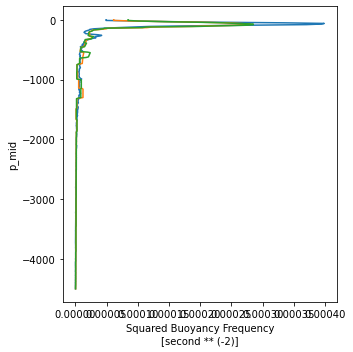

In [17]:
N2.N2.plot(y='p_mid',label='Updated Obs 2022',figsize=[5,5])
N2_CORE.N2.plot(y='p_mid',label='CORE')
N2_JRA.N2.plot(y='p_mid',label='JRA')
plt.tight_layout()

# Apply to data and model outputs

## N2 from Claus et al. (2016) data

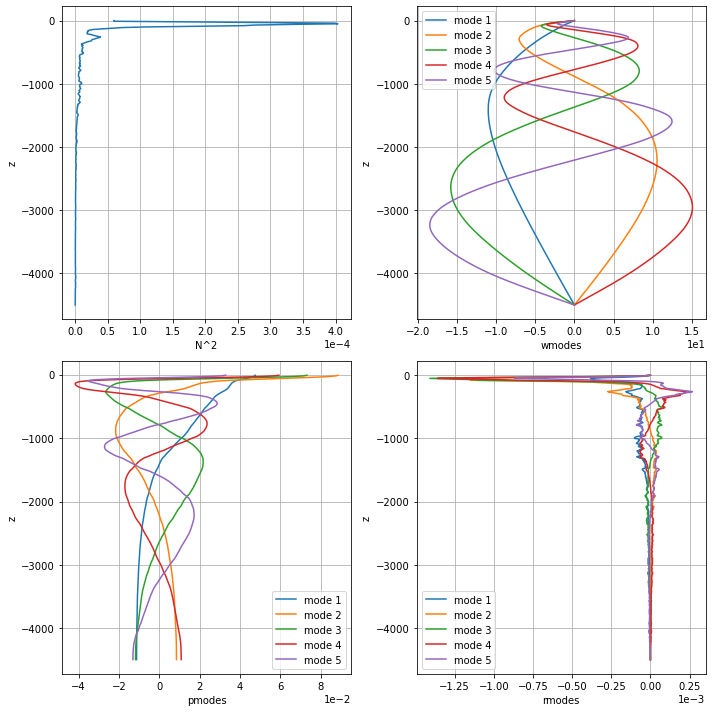

In [18]:
ds_moor['pstruc_i'] = ds_moor.pstruc.interp(depth_p=ds_moor.depth_w)
plot_modes(ds_moor.Nsq,abs(ds_moor.depth_w), 5, ds_moor.wstruc, ds_moor.pstruc_i,ds_moor.rstruc)

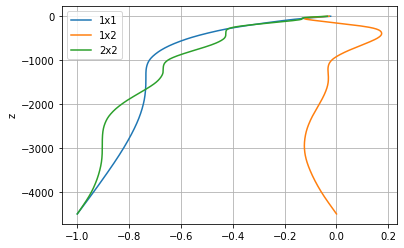

In [19]:
# check orthogonality
normal_mode_1 = ds_moor.pstruc.sel(mode=1)
normal_mode_2 = ds_moor.pstruc.sel(mode=4)
z = ds_moor.depth_p
dz = ds_moor.depth_p.diff('depth_p').isel(depth_p=0)
plt.plot((normal_mode_1 * normal_mode_1*dz).cumsum().squeeze(), z, label="1x1")
plt.plot((normal_mode_1 * normal_mode_2*dz).cumsum().squeeze(), z, label="1x2")
plt.plot((normal_mode_2 * normal_mode_2*dz).cumsum().squeeze(), z, label="2x2")

plt.ylabel("z")
plt.legend();
plt.grid()

In [20]:
(normal_mode_1 * normal_mode_2*dz).cumsum().squeeze()[-1]

<xarray.DataArray ()>
array(-5.35075022e-13)
Coordinates:
    depth_p  float64 -4.495e+03

<xarray.DataArray 'c' (mode: 5)>
array([2.4680237 , 1.32211895, 0.94717089, 0.74435359, 0.56715929])
Coordinates:
  * mode     (mode) int64 1 2 3 4 5
Attributes:
    long_name:  Gravity Wave Speed
    units:      meter / second

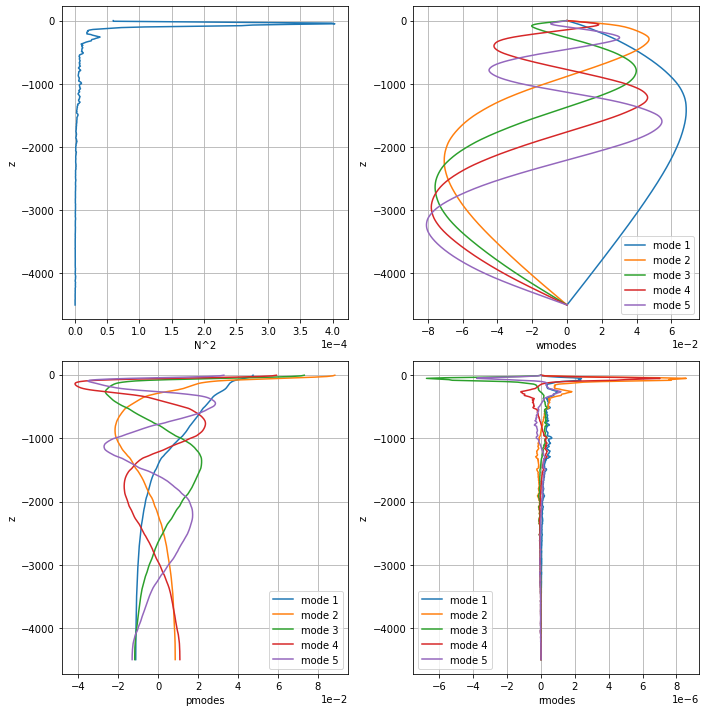

In [21]:
ds_claus = dynmodes(ds_moor.Nsq.values, abs(ds_moor.depth_w.values), Nmodes)
ds_claus
ds_claus.attrs['description'] = 'Vertical structure functions for stratification from mean CTD profile (Claus et al., 2016) dataset'+ file_name_claus

ds_claus['pstruc_i'] = ds_claus.pstruc.interp(depth_p=ds_claus.depth_w)
plot_modes(ds_claus.Nsq,  ds_claus.depth_w, 5, ds_claus.wstruc, ds_claus.pstruc_i,ds_claus.rstruc)
display(ds_claus.c[:5])

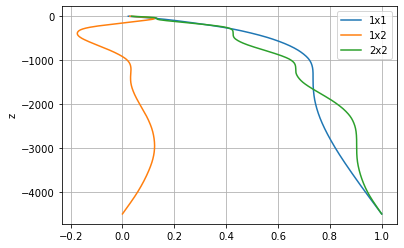

In [22]:
# check orthogonality
normal_mode_1 = ds_claus.pstruc.sel(mode=1)
normal_mode_2 = ds_claus.pstruc.sel(mode=4)
z = ds_claus.depth_p
dz = ds_claus.depth_p.diff('depth_p').isel(depth_p=0)
plt.plot((normal_mode_1 * normal_mode_1*dz).cumsum().squeeze(), -z, label="1x1")
plt.plot((normal_mode_1 * normal_mode_2*dz).cumsum().squeeze(), -z, label="1x2")
plt.plot((normal_mode_2 * normal_mode_2*dz).cumsum().squeeze(), -z, label="2x2")

plt.ylabel("z")
plt.legend();
plt.grid()

In [23]:
(normal_mode_1 * normal_mode_2*dz).cumsum().squeeze()[-1]

<xarray.DataArray ()>
array(-8.93369146e-13)
Coordinates:
    depth_p  float64 4.495e+03

## Updated mean CTD profile

<xarray.DataArray 'c' (mode: 5)>
array([2.50536778, 1.40003242, 0.98121251, 0.75565357, 0.57135359])
Coordinates:
  * mode     (mode) int64 1 2 3 4 5
Attributes:
    long_name:  Gravity Wave Speed
    units:      meter / second

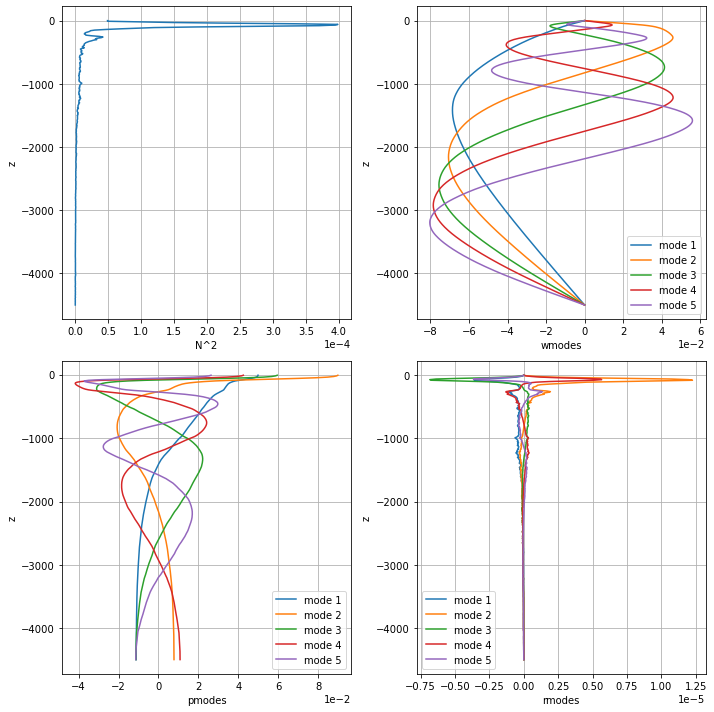

In [24]:
dsm_obs = dynmodes(N2.N2.values, abs(N2.p_mid.values),Nmodes)
dsm_obs.attrs['description'] = f'Vertical structure functions for stratification from mean CTD profile dataset {str(indir_obs)}/{file_name_obs}'
dsm_obs.to_netcdf((out_dir_data / out_obs), 
        engine='netcdf4')

dsm_obs['pstruc_i'] = dsm_obs.pstruc.interp(depth_p=dsm_obs.depth_w)
plot_modes(dsm_obs.Nsq,  dsm_obs.depth_w, 5, dsm_obs.wstruc, dsm_obs.pstruc_i,dsm_obs.rstruc)
display(dsm_obs.c[:5])

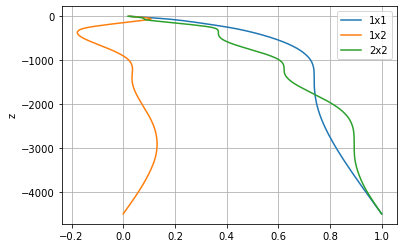

In [25]:
# check orthogonality
ds = dsm_obs
normal_mode_1 = ds.pstruc.sel(mode=1)
normal_mode_2 = ds.pstruc.sel(mode=4)
z = ds.depth_p
dz = ds.depth_p.diff('depth_p').isel(depth_p=0)
plt.plot((normal_mode_1 * normal_mode_1*dz).cumsum().squeeze(), -z, label="1x1")
plt.plot((normal_mode_1 * normal_mode_2*dz).cumsum().squeeze(), -z, label="1x2")
plt.plot((normal_mode_2 * normal_mode_2*dz).cumsum().squeeze(), -z, label="2x2")

plt.ylabel("z")
plt.legend();
plt.grid()

In [26]:
(normal_mode_1* normal_mode_2*dz).cumsum().squeeze()[-1]

<xarray.DataArray ()>
array(6.77675364e-13)
Coordinates:
    depth_p  float64 4.495e+03

### plot for presetation

In [27]:
ds = xr.open_dataset(Path(out_dir_data / out_obs)) 

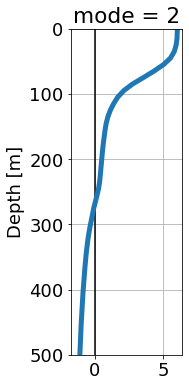

In [28]:
font = {'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)
ymin,ymax = 0,500
ds.depth_p.attrs['long_name']='Depth'
ds.mode.attrs['long_name']='Mode'
(ds.pstruc.sel(mode=2)*(4500**0.5)).plot.line(
    figsize = [2,6],linewidth=5,
    y='depth_p',ylim=[ymax,ymin])
plt.xlabel('')
plt.vlines(0,ymin,ymax,'k')
plt.grid()

## INALT20 JRA run

<xarray.DataArray 'c' (mode: 5)>
array([2.52926408, 1.43332644, 1.04868447, 0.8118458 , 0.5791029 ])
Coordinates:
  * mode     (mode) int64 1 2 3 4 5
Attributes:
    long_name:  Gravity Wave Speed
    units:      meter / second

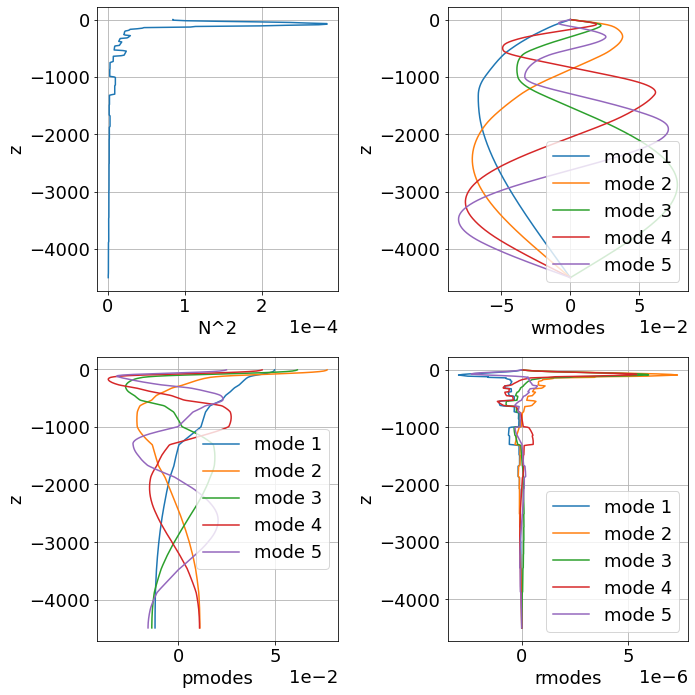

In [29]:
dsm_JRA = N2_JRA.N2.where(N2_JRA.N2.notnull(),drop=True)
dsm_JRA = dynmodes(dsm_JRA.values,dsm_JRA.p_mid.values,Nmodes)
dsm_JRA.attrs['description'] = f'Vertical structure functions for stratification from simulated mean N2 profile in INALT20 JRA, model output {str(files_JRA[0])[:49]}yyyymmdd_yyyymmdd{str(files_JRA[0])[66:]}'
dsm_JRA.to_netcdf((out_dir_data / out_JRA), 
        engine='netcdf4')

dsm_JRA['pstruc_i'] = dsm_JRA.pstruc.interp(depth_p=dsm_JRA.depth_w)
plot_modes(dsm_JRA.Nsq,  dsm_JRA.depth_w, 5, dsm_JRA.wstruc, dsm_JRA.pstruc_i,dsm_JRA.rstruc)
display(dsm_JRA.c[:5])

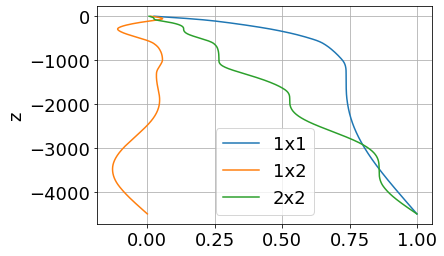

In [30]:
# check orthogonality
ds = dsm_JRA
normal_mode_1 = ds.pstruc.sel(mode=1)
normal_mode_2 = ds.pstruc.sel(mode=5)
z = ds.depth_p
dz = ds.depth_p.diff('depth_p').isel(depth_p=0)
plt.plot((normal_mode_1 * normal_mode_1*dz).cumsum().squeeze(), -z, label="1x1")
plt.plot((normal_mode_1 * normal_mode_2*dz).cumsum().squeeze(), -z, label="1x2")
plt.plot((normal_mode_2 * normal_mode_2*dz).cumsum().squeeze(), -z, label="2x2")

plt.ylabel("z")
plt.legend();
plt.grid()


## INALT20 CORE run

<xarray.DataArray 'c' (mode: 5)>
array([2.50916221, 1.42092249, 1.03643934, 0.80458424, 0.56857439])
Coordinates:
  * mode     (mode) int64 1 2 3 4 5
Attributes:
    long_name:  Gravity Wave Speed
    units:      meter / second

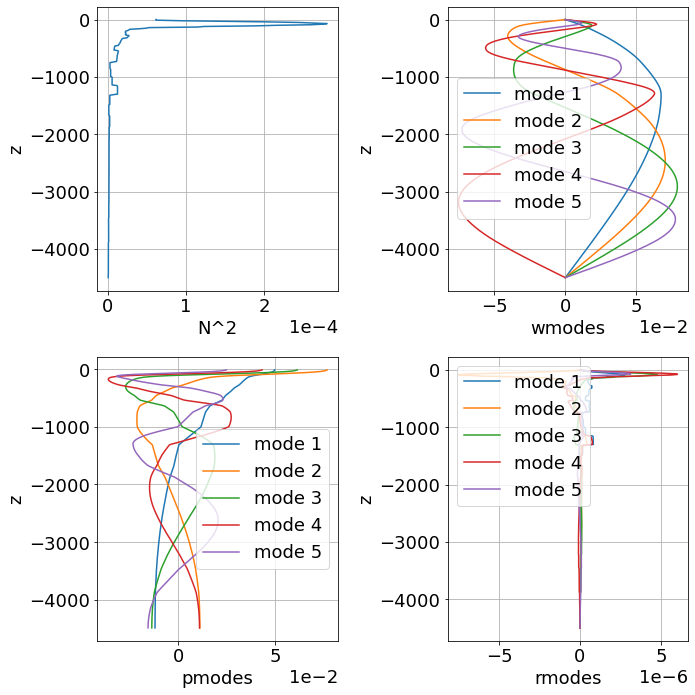

In [31]:
dsm_CORE = N2_CORE.N2.where(N2_CORE.N2.notnull(),drop=True)
dsm_CORE = dynmodes(dsm_CORE.values,dsm_CORE.p_mid.values,Nmodes)
dsm_CORE.attrs['description'] = f'Vertical structure functions for stratification from simulated mean N2 profile in INALT20 CORE, model output {str(files_CORE[0])[:49]}yyyymmdd_yyyymmdd{str(files_CORE[0])[66:]}'
dsm_CORE.to_netcdf((out_dir_data / out_CORE), 
        engine='netcdf4')

dsm_CORE['pstruc_i'] = dsm_JRA.pstruc.interp(depth_p=dsm_CORE.depth_w)
plot_modes(dsm_CORE.Nsq,  dsm_CORE.depth_w, 5, dsm_CORE.wstruc, dsm_CORE.pstruc_i,dsm_CORE.rstruc)
display(dsm_CORE.c[:5])

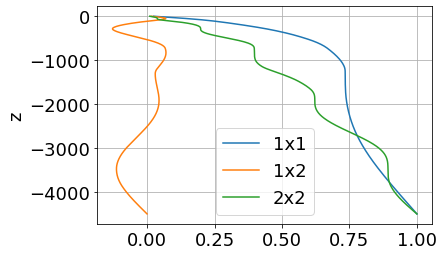

In [32]:
# check orthogonality
ds = dsm_CORE
normal_mode_1 = ds.pstruc.sel(mode=1)
normal_mode_2 = ds.pstruc.sel(mode=5)
z = ds.depth_p
dz = ds.depth_p.diff('depth_p').isel(depth_p=0)
plt.plot((normal_mode_1 * normal_mode_1*dz).cumsum().squeeze(), -z, label="1x1")
plt.plot((normal_mode_1 * normal_mode_2*dz).cumsum().squeeze(), -z, label="1x2")
plt.plot((normal_mode_2 * normal_mode_2*dz).cumsum().squeeze(), -z, label="2x2")

plt.ylabel("z")
plt.legend();
plt.grid()


## Compare model and observations

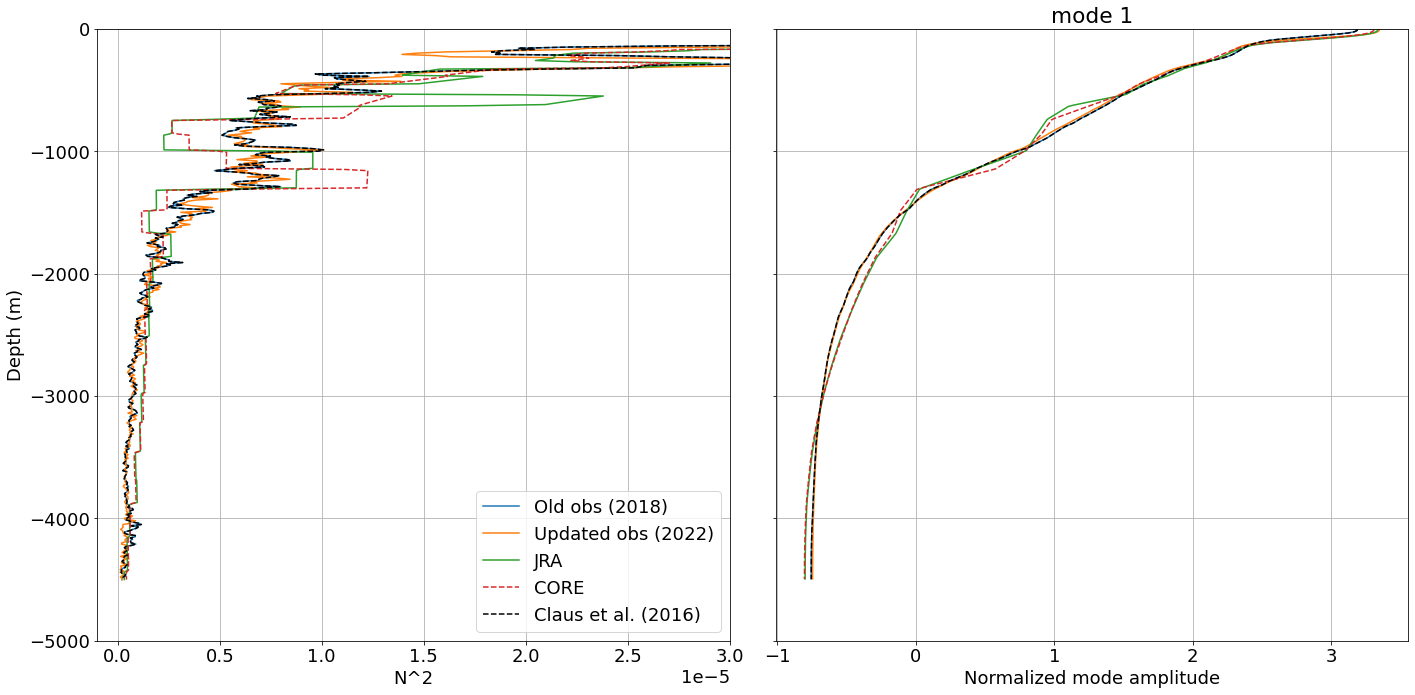

In [33]:
plot_modes2(1)
plt.savefig((out_dir_fig/'N2_profiles_and_mode_1_all.png'))

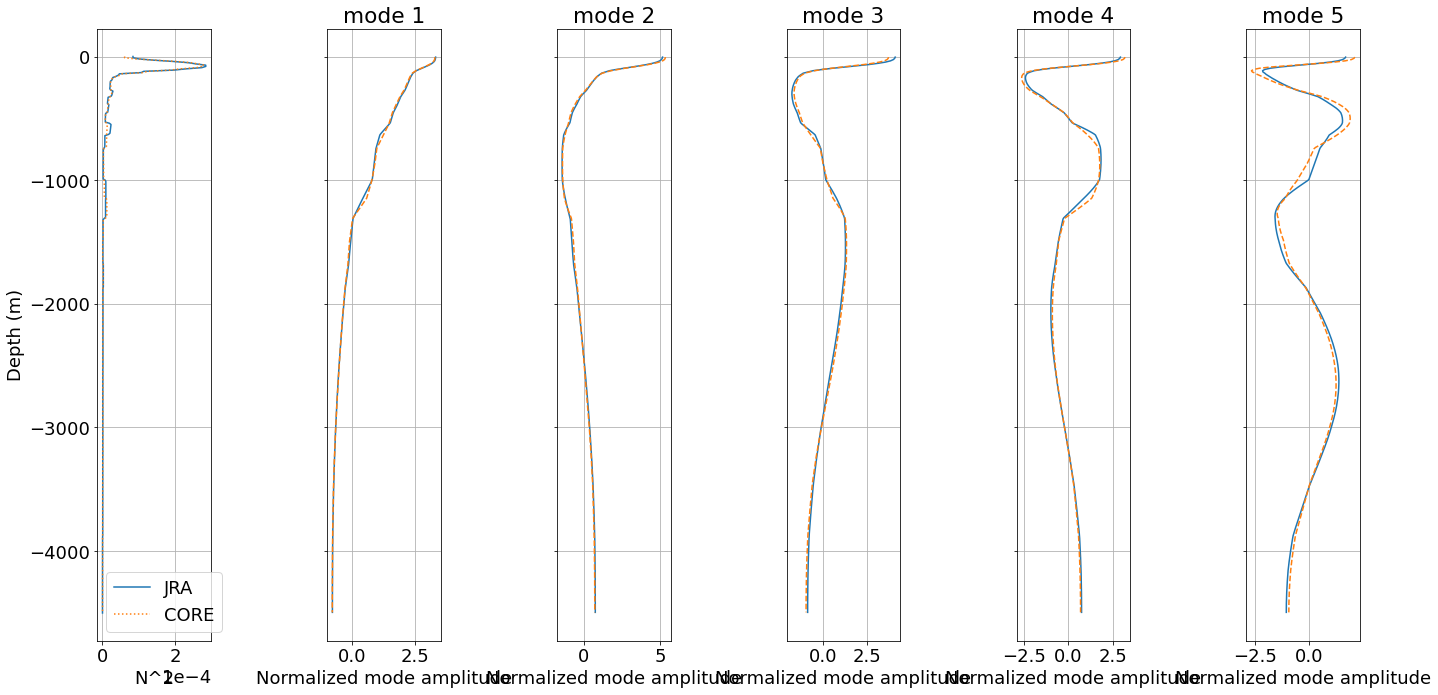

In [34]:
plot_modes3(5)

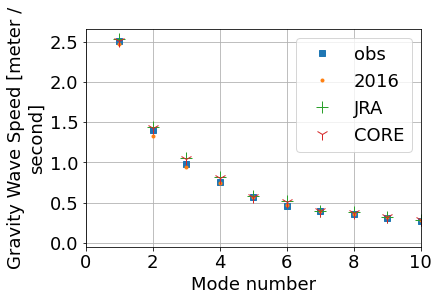

In [35]:
dsm_obs.c.plot.line('s',label='obs')
ds_moor.c.plot.line('.',label='2016')
dsm_JRA.c.plot.line('+',label='JRA',markersize=12)
dsm_CORE.c.plot.line('1',label='CORE',markersize=12)
plt.xlim([0,10])
plt.grid()
plt.legend()

plt.savefig((out_dir_fig/'c_first_10_modes_all.png'))

In [36]:
data = [dsm_obs.c.sel(mode=slice(0,5)).round(decimals=2).values,dsm_JRA.c.sel(mode=slice(0,5)).round(decimals=2).values,dsm_CORE.c.sel(mode=slice(0,5)).round(decimals=2).values]
pd.DataFrame(data, columns=["Mode 1", "Mode 2",'Mode 3','Mode 4','Mode 5'],index=['Obs','JRA','CORE'])

,Mode 1,Mode 2,Mode 3,Mode 4,Mode 5
Obs,2.51,1.40,0.98,0.76,0.57
JRA,2.53,1.43,1.05,0.81,0.58
CORE,2.51,1.42,1.04,0.80,0.57
